In [1]:
# Importing necessary libraries for the analysis.
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import csv
import math
import json
from scipy.ndimage import uniform_filter1d
from tqdm import tqdm


from utils import *
from autoencoder import Autoencoder
from diffusion_networks import *
from sampler import *

In [61]:
# Defining the constants and configurations used throughout the notebook.
k = 50
batch_size = 32 # 256 Largest possible batch size that fits on the GPU w.f32
on_remote = False
spacing = 10

iterations = 2101000
spinup = 1001
p_train = 0.8
mean_data = 0.003394413273781538
std_data = 9.174626350402832

data_path = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_SUBS_{iterations}.npy') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_SUBS_{iterations}.npy')

#ae-2ds-32f-1l-150e-L1-0wd-0.00001l1
mean_data_latent = -0.6132266521453857
std_data_latent = 5.066834926605225
std_residual_latent =5.375336170196533

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Loading

In [62]:
train_dataset = QGSamplesDataset(data_path, 'train', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)
val_dataset = QGSamplesDataset(data_path, 'val', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)
#test_dataset = QGSamplesDataset(data_path, 'test', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
shuffled_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load Models

In [4]:
autoencoder_date = '2024-02-21'
autoencoder_model = 'ae-2ds-32f-1l-150e-L1-0wd-0.00001l1' #'ae-3ds-16f-2l-150e-L1-0wd-0.00001l1'# 

autoencoder_path = Path(f'/nobackup/smhid20/users/sm_maran/results/{autoencoder_date}/{autoencoder_model}/') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/results/{autoencoder_date}/{autoencoder_model}/')
saved_model = torch.load(autoencoder_path / 'best_model.pth')

with open(autoencoder_path / 'config.json', 'r') as json_file:
    parameters = json.load(json_file)

filters = parameters['filters']
latent_dim = parameters['latent_dim']
no_downsamples = parameters['no_downsamples']

autoencoder = Autoencoder(filters= filters, no_latent_channels=latent_dim, no_downsamples=no_downsamples)
autoencoder.load_state_dict(saved_model)
autoencoder.to(device)
autoencoder.eval()

print("Autoencoder loaded successfully!")

Autoencoder loaded successfully!


In [5]:
diffusion_date = '2024-02-29'
result_model = f'ncsnpp-f32-k{k}'

result_path = Path(f'/nobackup/smhid20/users/sm_maran/results/{diffusion_date}/{result_model}/') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/results/{diffusion_date}/{result_model}/')
saved_model = torch.load(result_path / 'best_model.pth')

with open(result_path / 'config.json', 'r') as json_file:
    parameters = json.load(json_file)

filters = parameters['filters']
model_name = parameters['model']
k = parameters['k']

forecasting = True
model = GCPrecond(filters=filters, img_channels=2 if forecasting else 1, model=model_name, img_resolution = 16)

model.load_state_dict(saved_model)
model.to(device)
model.eval()
print("Diffusion Model loaded successfully!")

Diffusion Model loaded successfully!


In [21]:
def calculate_latent_mean_std():
    # Calculate mean and var
    # Initialize variables for mean and standard deviation
    mean_data_latent = 0.0
    std_data_latent = 0.0
    count = 0
    #autoencoder.to('cpu')
    # Iterate over the batches in train_loader
    autoencoder.eval()
    with torch.no_grad():
        for current, next in train_loader:
            # Get the input data from the batch
            latent = autoencoder.encoder(current)
            next_latent = autoencoder.encoder(next)
            
            inputs = next_latent -  latent

            count += inputs.size(0)

            # Calculate the sum of the input data
            mean_data_latent += torch.sum(inputs)
            std_data_latent += torch.sum(inputs ** 2)
            #print(mean_data_latent/count, std_data_latent/count, count)
            
        # Calculate the mean and standard deviation
        count = count * inputs[0].cpu().detach().numpy().size
        # TODO
        mean_data_latent /= count
        std_data_latent = torch.sqrt(std_data_latent / count - mean_data_latent ** 2)

        # Print the mean and standard deviation
        print("Mean:", mean_data_latent.item())
        print("Standard Deviation:", std_data_latent.item())

    return mean_data_latent, std_data_latent

calculate_latent_mean_std()
print(mean_data_latent, std_data_latent, std_residual_latent)

Mean: -6.831114205851918e-06
Standard Deviation: 5.375336170196533
-0.03832172974944115 1.3086596727371216 6.599302768707275


# Training Diffusion

### Sampling for training (Change)

In [ ]:
def sample_and_plot(net, class_labels = None, img_channels=1):
    sampler_fn = complete_edm_sampler
    
    latents = torch.randn([1, img_channels, net.img_resolution, net.img_resolution], device=device)
    image, images  = sampler_fn(net, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)

    # TODO Fix such that you can plot smaller resolutions
    plt.figure(figsize=(images.shape[0], 1))
    plt.tight_layout()
    for i in range(images.shape[0]):
        plt.subplot(1, images.shape[0], i+1)
        plt.imshow(images[i,0, 0].cpu().detach().numpy())
        plt.axis('off')
    plt.show()
    
sample_and_plot(model, img_channels=2)

In [ ]:
def plot_forecasts_from_residual(model, num_images=4):
    for previous, current in train_loader:
        with torch.no_grad():
            previous_latent = autoencoder.encoder(previous)
        
        previous_latent = previous_latent[0].unsqueeze(0)
        break

    img_channels = previous_latent.size(1)
    class_labels = previous_latent.repeat(num_images, 1, 1, 1)

    sampler_fn = edm_sampler
    latents = torch.randn([num_images, img_channels, model.img_resolution, model.img_resolution], device=device)
    
    residuals = sampler_fn(model, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)

    predicted_latent = previous_latent + residuals * std_residual_latent

    predicted = autoencoder.decoder(predicted_latent.to(torch.float32)).cpu().detach().numpy()[:,0]
    previous = previous[0,0].cpu().detach().numpy()
    current = current[0,0].cpu().detach().numpy()

    vmin = min(predicted.min(), current.min(), previous.min())
    vmax = max(predicted.max(), current.max(), previous.max())

    fig, axes = plt.subplots(1, 2+num_images, figsize=(15, 5))

    axes[0].imshow(previous, vmin=vmin, vmax=vmax)
    axes[0].axis('off')
    axes[0].set_title('Previous')

    axes[1].imshow(current, vmin=vmin, vmax=vmax)
    axes[1].axis('off')
    axes[1].set_title('Truth')

    for i in range(num_images):
        axes[i+2].imshow(predicted[i], vmin=vmin, vmax=vmax)
        axes[i+2].axis('off')
        axes[i+2].set_title('Sampled')

    plt.tight_layout()
    plt.show()

plot_forecasts_from_residual(model)

### Training (Change)

In [22]:
# Setup for training

forecasting = True

num_epochs = 1

model = GCPrecond(filters=32, img_channels=2 if forecasting else 1, img_resolution = 16)
print("Num params: ", sum(p.numel() for p in model.parameters()))

model.to(device)
 
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)
#optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.001)
loss_fn = GCLoss()

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
warmup_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=0.001, end_factor=1.0, total_iters=1000)
loss_values = []
val_loss_values = []
best_val_loss = float('inf')

# Setup for logging
log_file_path = 'training_log.csv'
with open(log_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Epoch', 'Average Training Loss', 'Validation Loss'])

Num params:  3541473


In [23]:
# Training
import time
from tqdm import tqdm

# Training loop

log_interval = 100#len(train_loader) // 4

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()  # Set model to training mode
    total_train_loss = 0

    current_loss = 0
    count = 0

    for previous, current in tqdm(train_loader):
        count += 1
        optimizer.zero_grad()

        with torch.no_grad():
            current_latent = autoencoder.encoder(current)
            previous_latent = None

            if forecasting:
                previous_latent = autoencoder.encoder(previous)
                target_latent = (current_latent - previous_latent) / std_residual_latent
            else:
                target_latent = (current_latent - mean_data_latent) / std_data_latent
            
        loss = loss_fn(model, target_latent, previous_latent)

        total_train_loss += loss.item()
        current_loss += loss.item()

        loss.backward()
        optimizer.step()

        if count % log_interval == 0:
            # Calculate and log the current average loss
            current_loss = current_loss / count

            print(f'Average Loss: {current_loss:.4f}')

            current_loss = 0
            count = 0
        
        warmup_scheduler.step()

            
    avg_train_loss = total_train_loss / len(train_loader)
    
    train_time = time.time() - start_time
    start_time = time.time()

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for previous, current in tqdm(val_loader):
            current_latent = autoencoder.encoder(current)
            previous_latent = None

            if forecasting:
                previous_latent = autoencoder.encoder(previous)
                target_latent = (current_latent - previous_latent) / std_residual_latent
            else:
                target_latent = (current_latent - mean_data_latent) / std_data_latent
            
            loss = loss_fn(model, target_latent, previous_latent)
            
            total_val_loss += loss.item()
            
    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    val_time = time.time() - start_time
    start_time = time.time()
    
    scheduler.step()
        
    if forecasting:
        #plot_ensemble(model)
        #plot_forecasts_from_residual(model)
        pass
    else:
        pass
        #sample_and_plot(model, img_channels=1)

    sample_time = time.time() - start_time
    
    # Log to CSV    
    loss_values.append([avg_train_loss])
    val_loss_values.append(avg_val_loss)  # Assuming val_loss_values list exists
    
    # Log to CSV
    with open(log_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch+1, avg_train_loss, avg_val_loss])
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    print(f'Training time: {train_time:.5f}s, Validation time: {val_time:.5f}s, Sample time: {sample_time:.5f}s')
    torch.save(model.state_dict(), 'final_model.pth')


# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.plot(loss_plot[1:], label='Training Loss', color='blue')

plt.plot(val_loss_values[1:], label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

  0%|          | 0/16800 [00:00<?, ?it/s]

  0%|          | 28/16800 [00:11<1:57:34,  2.38it/s]


KeyboardInterrupt: 

# Generation

In [6]:
def generate_ensemble_from_single_random(model, n_ens=10, selected_loader = shuffled_val_loader, sampler_fn=edm_sampler):
    model.eval()

    for previous, current in selected_loader:
        previous_unbatched = previous[0].unsqueeze(0)
        current_unbatched = current[0].unsqueeze(0)
        break

    with torch.no_grad():
        previous_latent = autoencoder.encoder(previous_unbatched)

        class_labels = previous_latent.repeat(n_ens, 1, 1, 1)
        latents = torch.randn_like(class_labels, device=device)
        
        predicted_residuals = sampler_fn(model, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)
        predicted_latent = previous_latent + predicted_residuals * std_residual_latent
        
        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

        predicted_unnormalized = predicted * std_data + mean_data
        current_unnormalized = current_unbatched * std_data + mean_data
        previous_unnormalized = previous_unbatched * std_data + mean_data

    return predicted_unnormalized, current_unnormalized, previous_unnormalized

#predicted_unnormalized, current_unnormalized, previous_unnormalized = generate_ensemble_from_single_random(model, n_ens=1000, selected_loader = shuffled_val_loader, sampler_fn=edm_sampler)

In [8]:
# Need to choose batch_size such that batch_size*n_ens fits on GPU
def generate_ensemble_from_batch(model, previous, n_ens=10, sampler_fn=edm_sampler):
    model.eval()

    with torch.no_grad():
        previous_latent = autoencoder.encoder(previous)
        class_labels = previous_latent.repeat(n_ens, 1, 1, 1)

        latents = torch.randn_like(class_labels, device=device)

        predicted_residuals = sampler_fn(model, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)

        predicted_latent = class_labels + predicted_residuals * std_residual_latent
        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

        predicted_unnormalized = predicted * std_data + mean_data

        predicted_unnormalized = predicted_unnormalized.view(n_ens, previous.size(0), previous.size(1), previous.size(2), previous.size(3))

    return predicted_unnormalized

#predicted_unnormalized = generate_ensemble_from_batch(model, next(iter(shuffled_val_loader))[0], n_ens=10)

# Evaluation

### Calculation functions

In [9]:
def calculate_RMSE(predicted, truth):
    dims_to_include = list(range(1, truth.dim()))
    return torch.sqrt(torch.mean((predicted - truth) ** 2, dim=dims_to_include)).cpu().detach().numpy()

In [10]:
def calculate_climatology(selected_loader):
    mean = 0
    count = 0
    with torch.no_grad():
        for _, current in tqdm(selected_loader):
            mean += torch.sum(current, dim=0)
            count += current.size(0)
    mean = mean / count
    return mean

#calculate_climatology(shuffled_val_loader)

In [39]:
def calculate_skill_and_spread_score(forecast, truth):
    ens_mean = forecast.mean(dim=0)
    dims_to_include = list(range(1, truth.dim()))

    skill = ((ens_mean - truth)**2).mean(dim=dims_to_include).sqrt()
    N = forecast.size(0)

    spread = (((ens_mean - forecast)**2).sum(dim=0)/(N - 1)).mean(dim=dims_to_include).sqrt()

    ratio = np.sqrt((N+1)/N) * spread / skill
    return skill.cpu().detach().numpy(), spread.cpu().detach().numpy(), ratio.cpu().detach().numpy()

In [51]:
# Batched input (n_ens, batch_size, img_channels, img_resolution, img_resolution)

def calculate_CRPS(forecast, truth):
    dims_to_include = list(range(1, truth.dim()))

    a = (forecast - truth).norm(dim=0, p=1)
    b = (forecast.unsqueeze(1) - forecast.unsqueeze(0)).abs().mean(dim=(0,1)) * 0.5
    return (a - b).mean(dim=dims_to_include).cpu().detach().numpy()

In [52]:
def calculate_brier_score(forecast, truth, threshold=10):
    dims_to_include = list(range(1, truth.dim()))

    px = (forecast > threshold).to(torch.float32).mean(dim=0)
    py = (truth > threshold).to(torch.float32)
    
    brier = ((px - py)**2).mean(dim=dims_to_include)
    return brier.cpu().detach().numpy()

In [64]:
# Batched input (n_ens, batch_size, img_channels, img_resolution, img_resolution)

def calculate_covtrace(forecast):
    covtrace = np.zeros(forecast.size(1))
    for i in range(forecast.size(1)):
        forecast_i = forecast[:,i]
        covtrace[i] = torch.trace(torch.cov(forecast.view(forecast_i.size(0), -1)))

    return covtrace

In [34]:
# This does not work for unbatched data currently
forecast, truth, _ = generate_ensemble_from_single_random(model, n_ens=100, selected_loader = shuffled_val_loader, sampler_fn=edm_sampler)
skill, spread, ratio = calculate_skill_and_spread_score(forecast, truth)
crps = calculate_CRPS(forecast, truth)
brier = calculate_brier_score(forecast, truth, 20)

print(f"Skill: {skill:.2f}, Spread: {spread:.2f}, Ratio: {ratio:.3f}, CRPS: {crps:.0f}, Brier: {brier:.4f}")

torch.Size([100, 1, 65, 65]) torch.Size([1, 65, 65]) torch.Size([1]) torch.Size([1, 1, 65, 65]) torch.Size([1, 65, 65]) [1, 2, 3]
Skill: 2.04, Spread: 2.26, Ratio: 1.112, CRPS: 150, Brier: 0.0078


### Plots

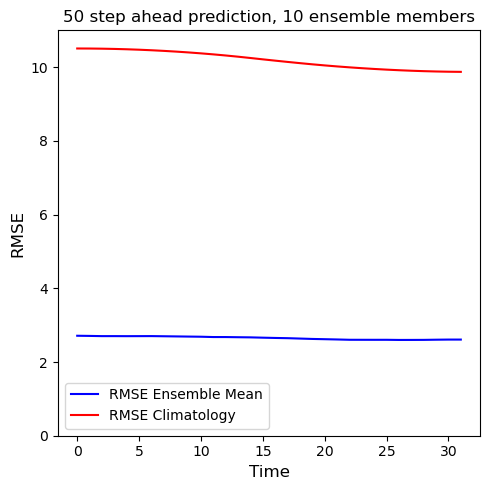

In [15]:
# Important rmse plot

def rmse_plot(model, n_ens=1, n_batches=1, selected_loader=val_loader):
    model.eval()

    result = {}
    result['rmse_model'] = np.zeros(n_batches*batch_size)
    result['rmse_clim'] = np.zeros(n_batches*batch_size)

    with torch.no_grad():
        for count, (previous, current) in enumerate(selected_loader):
            if count >= n_batches:
                break

            predicted_unnormalized = generate_ensemble_from_batch(model, previous, n_ens=n_ens)

            current_unnormalized = current * std_data + mean_data
            previous_unnormalized = previous * std_data + mean_data

            #  Note that this is kind of cheating since we are using the validation set to calculate the climatology.
            #  More realistic if we have a larger batch size.
            climatology = previous_unnormalized.mean(dim=0)

            ensemble_mean = predicted_unnormalized.mean(dim=0)

            rmse_model = calculate_RMSE(ensemble_mean, current_unnormalized)
            rmse_clim = calculate_RMSE(climatology, current_unnormalized)

            result['rmse_model'][count*batch_size:count*batch_size+rmse_model.size] = rmse_model
            result['rmse_clim'][count*batch_size:count*batch_size+rmse_model.size] = rmse_clim

    return result


n_ens = 10
n_batches = 1
running_mean = 100

result = rmse_plot(model, n_ens, n_batches)
rmse_model, rmse_clim = result['rmse_model'], result['rmse_clim']

plt.figure(figsize=(5,5))
plt.title(f'{k} step ahead prediction, {n_ens} ensemble members')
plt.plot(uniform_filter1d(rmse_model, size=running_mean), label='RMSE Ensemble Mean', color='b')
plt.plot(uniform_filter1d(rmse_clim, size=running_mean), label='RMSE Climatology', color='r')
plt.ylim(0,11)
plt.xlabel('Time', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

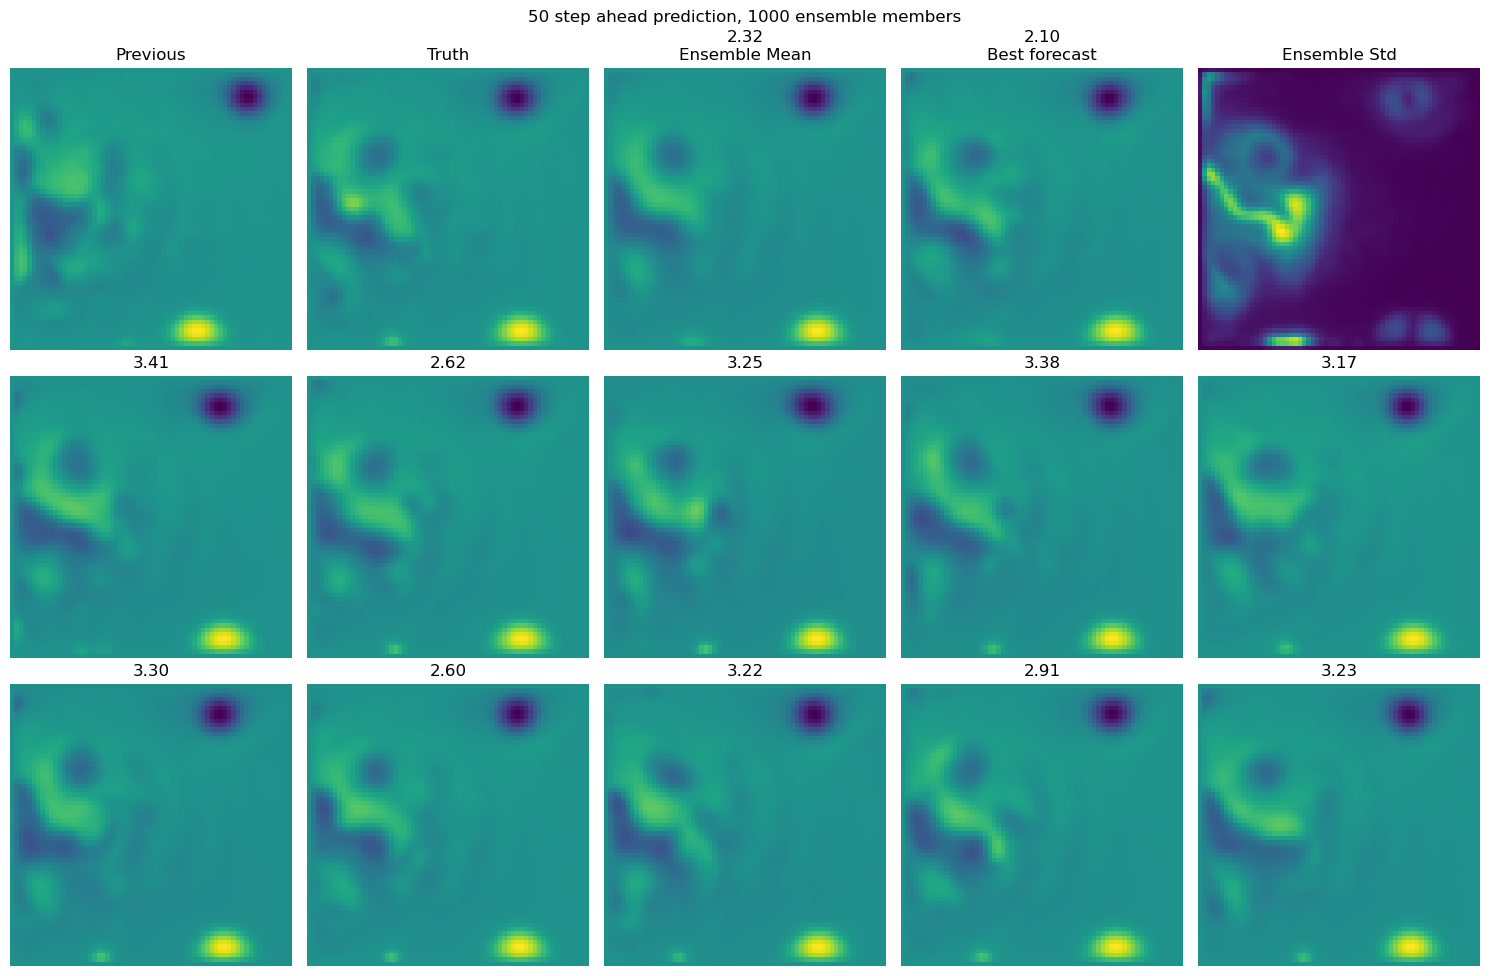

In [16]:
# Important plot for the ensemble forecast

def ensemble_plot(model, selected_loader=shuffled_val_loader, n_ens=10):
    
    predicted_unnormalized, current_unnormalized, previous_unnormalized = generate_ensemble_from_single_random(model, n_ens, selected_loader)
    
    ensemble_mean = predicted_unnormalized.mean(dim=0)
    ensemble_rmses = calculate_RMSE(predicted_unnormalized, current_unnormalized)
    ensemble_skill = calculate_RMSE(ensemble_mean, current_unnormalized)[0]
    ensemble_std = predicted_unnormalized.std(dim=0)
    best_forecast = predicted_unnormalized[np.argmin(ensemble_rmses)]
    best_rmse = ensemble_rmses[np.argmin(ensemble_rmses)]

    def plot_image(ax, image, title):
        image = image.cpu().detach().numpy().reshape((65,65))
        ax.imshow(image)
        ax.set_title(title)
        ax.axis('off')

    plt.set_cmap('viridis')
    no_ens_rows = 2

    fig, axes = plt.subplots(1+no_ens_rows, 5, figsize=(15, 10))
    fig.suptitle(f'{k} step ahead prediction, {n_ens} ensemble members')

    plot_image(axes[0,0], previous_unnormalized, "Previous")
    plot_image(axes[0,1], current_unnormalized, "Truth")
    plot_image(axes[0,2], ensemble_mean, f"{ensemble_skill:.2f}\nEnsemble Mean")
    plot_image(axes[0,3], best_forecast, f"{best_rmse:.2f}\nBest forecast")
    plot_image(axes[0,4], ensemble_std, "Ensemble Std")

    count = 0
    for i in range(no_ens_rows):
        for j in range(5):
            plot_image(axes[1+i,j], predicted_unnormalized[count], f"{ensemble_rmses[count]:.2f}")
            count+=1
    
    plt.tight_layout()
    plt.show()
    
    return ensemble_rmses, ensemble_skill

ensemble_rmses, ensemble_skill = ensemble_plot(model, selected_loader=shuffled_val_loader, n_ens=1000)


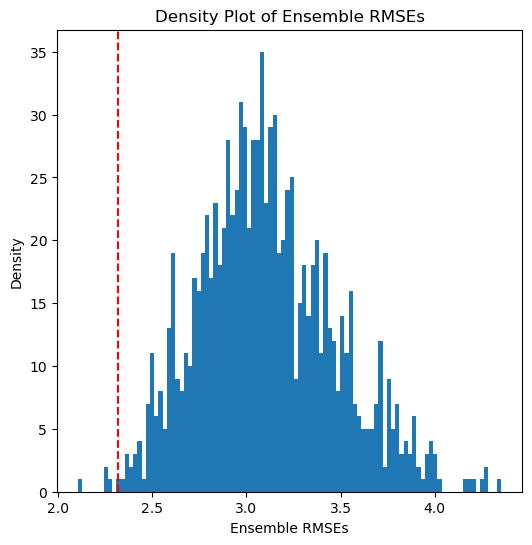

In [17]:
def rmse_density_plot(ensemble_rmses, ensemble_skill):
    plt.figure(figsize=(6,6))
    plt.hist(ensemble_rmses, bins=100)
    plt.axvline(ensemble_skill, color='red', linestyle='--')
    plt.xlabel('Ensemble RMSEs')
    plt.ylabel('Density')
    plt.title('Density Plot of Ensemble RMSEs')
    plt.show()

rmse_density_plot(ensemble_rmses, ensemble_skill)

### Pipe

In [65]:
def evaluation_pipeline(model, n_ens=10, n_batches=1, selected_loader=val_loader, sampler_fn=edm_sampler):
    model.eval()

    results = {'skill': [], 'spread': [], 'ratio': [], 'crps': [], 'brier': [], 'covtrace': []}
    with torch.no_grad():
        for count, (previous, current) in (enumerate(selected_loader)):
            if count >= n_batches:
                break

            predicted_unnormalized = generate_ensemble_from_batch(model, previous, n_ens=n_ens)

            current_unnormalized = current * std_data + mean_data
            previous_unnormalized = previous * std_data + mean_data

            skill, spread, ratio = calculate_skill_and_spread_score(predicted_unnormalized, current_unnormalized)
            crps = calculate_CRPS(predicted_unnormalized, current_unnormalized)
            brier = calculate_brier_score(predicted_unnormalized, current_unnormalized, 20)
            covtrace = calculate_covtrace(predicted_unnormalized)
            
            # Can make this easier by preallocating results
            results['skill'].append(skill)
            results['spread'].append(spread)
            results['ratio'].append(ratio)
            results['crps'].append(crps)
            results['brier'].append(brier)
            results['covtrace'].append(covtrace)

    results = {key: np.concatenate(value) for key, value in results.items()}
    return results

res = evaluation_pipeline(model, n_ens=2, n_batches=2, selected_loader=val_loader, sampler_fn=edm_sampler)

In [66]:
res

{'skill': array([3.3139431, 3.781234 , 2.7924988, 3.3340929, 2.7315457, 3.2925003,
        3.6390436, 4.126769 , 2.6885011, 2.6498456, 3.089872 , 2.983286 ,
        2.8143466, 2.7835014, 2.95136  , 2.8033893, 1.9368805, 3.199504 ,
        3.9832685, 3.9296153, 3.3443174, 3.8256567, 4.009661 , 3.507803 ,
        2.9723651, 2.7489645, 3.0299308, 3.0809603, 3.2617228, 3.733099 ,
        3.2584257, 4.385755 , 4.5398755, 2.695992 , 3.487393 , 3.7367384,
        2.2886455, 2.9603612, 2.67063  , 2.4861684, 3.0788994, 2.8571982,
        2.4615026, 2.4079742, 4.05379  , 2.8875275, 3.1815042, 2.977857 ,
        2.7788417, 3.5265017, 2.598252 , 2.6970658, 1.7603655, 1.7628065,
        2.4751124, 1.8659917, 1.9350677, 2.259664 , 2.6061363, 2.8988876,
        2.7844622, 2.5879424, 2.192449 , 2.4898126], dtype=float32),
 'spread': array([2.1717758, 2.6613636, 2.6198394, 2.1384144, 2.1922047, 3.8269923,
        2.0008757, 2.1585715, 1.8108932, 1.9165847, 2.678926 , 2.6232638,
        2.5416865, 1.845

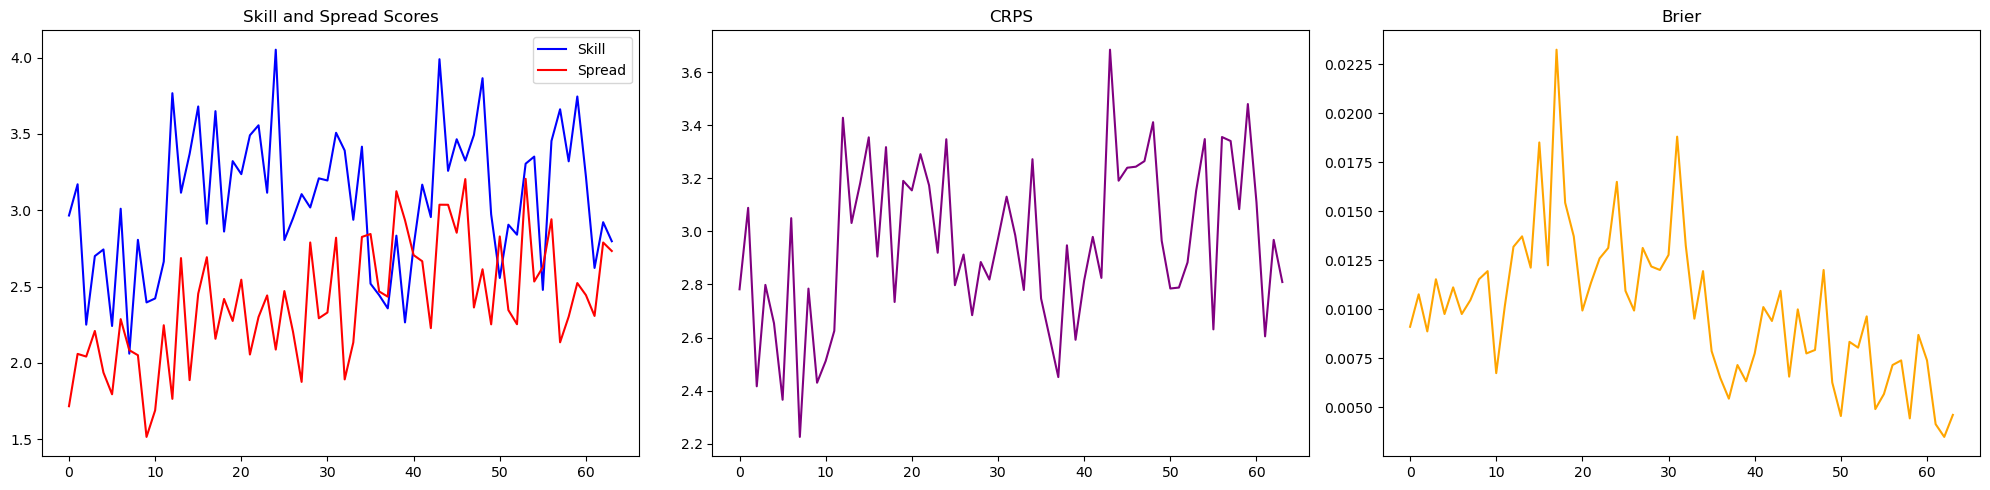

In [60]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].plot(res['skill'], label='Skill', color='blue')
axes[0].set_title('Skill and Spread Scores')
axes[0].plot(res['spread'], label='Spread', color='red')
axes[0].legend()

#axes[2].plot(res['ratio'], label='Ratio', color='green')
#axes[2].set_title('Ratio')

axes[1].plot(res['crps'], label='CRPS', color='purple')
axes[1].set_title('CRPS')

axes[2].plot(res['brier'], label='Brier', color='orange')
axes[2].set_title('Brier')

plt.tight_layout()

plt.show()

In [39]:
torch.cov(forecast.view(forecast.size(0), -1)).trace()

NameError: name 'forecast' is not defined

### Variance/ RMSE

Still needs to clean up this.

In [16]:
from utils import NWPDataset

iterations = 2101000
n_val = 210000

nwp_data_path = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_LRES_{iterations}_n_{n_val}_k_{k}.npy') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_LRES_{iterations}_n_{n_val}_k_{k}.npy')

nwp_dataset = NWPDataset(nwp_data_path, n_val, device)
nwp_loader = DataLoader(nwp_dataset, batch_size=batch_size, shuffle=False)


In [20]:
import tqdm

def validation_pipeline(model, n_ens=10, sampler_fn=edm_sampler):
    model.eval()
    count = 0
    results = {'skill': [], 'spread': [], 'ratio': [], 'crps': [], 'brier': [], 'nwp': [], 'covtrace': []}

    for data, nwp in zip(val_loader, nwp_loader):

        previous, current = data
        
        for i in range(batch_size):
            print(count)
            count+=1
            with torch.no_grad():
                previous_datapoint = previous[i]
                current_datapoint = current[i] * std_data + mean_data
                forecast = generate_forecast(model, previous_datapoint, n_ens, sampler_fn)
                
                skill, spread, ratio = calculate_skill_and_spread_score(forecast, current_datapoint)
                crps = calculate_CRPS(forecast, current_datapoint)
                brier = calculate_brier_score(forecast, current_datapoint, 20)
                covtrace = torch.cov(forecast.view(forecast.size(0), -1)).trace().item()

                nwp_datapoint = nwp[i]
                rmse_nwp = ((nwp_datapoint - current_datapoint)**2).mean().sqrt().item()

                results['nwp'].append(rmse_nwp)
                results['covtrace'].append(covtrace)

                results['skill'].append(skill)
                results['spread'].append(spread)
                results['ratio'].append(ratio)
                results['crps'].append(crps)
                results['brier'].append(brier)

            if count >= 1000:
                return results

    return results

res = validation_pipeline(model, n_ens=100)

0
1
2
3
4
5
6
7
8
9
10
11
12
13


KeyboardInterrupt: 

In [14]:
print_memory_usage()

Allocated Memory: 16053248 bytes
Cached Memory: 16777216 bytes


In [166]:
rmse_nwp = []
rmse_model = []
var_model = []
skill_model = []
spread_model = []
crps_model = []
brier_model = []

In [167]:
# Zip ignores longer loader

count = 0
max_count = 1000
with torch.no_grad():
    for nwp, data in zip(nwp_loader, val_loader):
        
        if count > max_count:
            break
        previous, current = data
        current = current * std_data + mean_data

        for i in range(batch_size):
            print(count)
            previous_datapoint = previous[i]
            current_datapoint = current[i]
            nwp_datapoint = nwp[i]
            forecast = generate_forecast(model, previous_datapoint, n_ens=100, sampler_fn=edm_sampler)
            
            rmse_model.append(((forecast - current_datapoint)**2).mean(dim=(1,2,3)).sqrt().cpu().detach().numpy())
            rmse_nwp.append(((nwp_datapoint - current_datapoint)**2).mean().sqrt().cpu().detach().item())
            var_model.append(torch.cov(forecast.view(forecast.size(0), -1)).trace().item())

            truth = current_datapoint
            skill, spread, ratio = calculate_skill_and_spread_score(forecast, truth)
            skill_model.append(skill)
            spread_model.append(spread)
            crps = calculate_CRPS(forecast, truth)
            crps_model.append(crps)
            brier = calculate_brier_score(forecast, truth, 20)
            brier_model.append(brier)
        
            count +=1 
            if count > max_count:
                break

rmse_model = np.array(rmse_model)
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [259]:
# Zip ignores longer loader

count = 0
max_count = 235
with torch.no_grad():
    for nwp, data in zip(nwp_loader, val_loader):
        
        if count >= max_count:
            break
        previous, current = data
        current = current * std_data + mean_data

        for i in range(batch_size):
            print(count)
            previous_datapoint = previous[i]
            current_datapoint = current[i]
            nwp_datapoint = nwp[i]
            
        
            count +=1 
            if count == max_count:
                forecast = generate_forecast(model, previous_datapoint, n_ens=100, sampler_fn=edm_sampler)
                truth = current_datapoint
                break

    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234


tensor(8.2518, device='cuda:0')
11.79115104675293
10.468219757080078


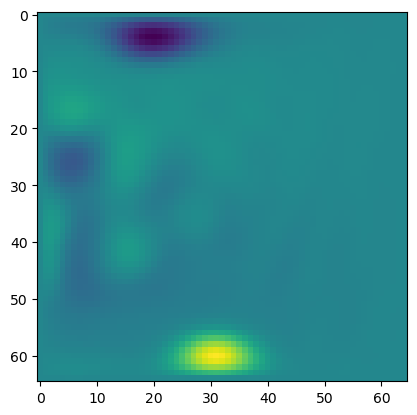

In [263]:
plt.imshow(truth.view(65,65).cpu().detach().numpy())
plt.imshow(forecast.mean(dim=0).view(65,65).cpu().detach().numpy())
#plt.imshow(nwp_datapoint.view(65,65).cpu().detach().numpy())
#plt.imshow(forecast[10].view(65,65).cpu().detach().numpy())

print(((truth - forecast.mean(dim=0))**2).mean().sqrt())
print(((truth - nwp_datapoint)**2).mean().sqrt().item())
print(((truth - forecast[10])**2).mean().sqrt().item())

In [168]:
rmse_model = np.array(rmse_model)


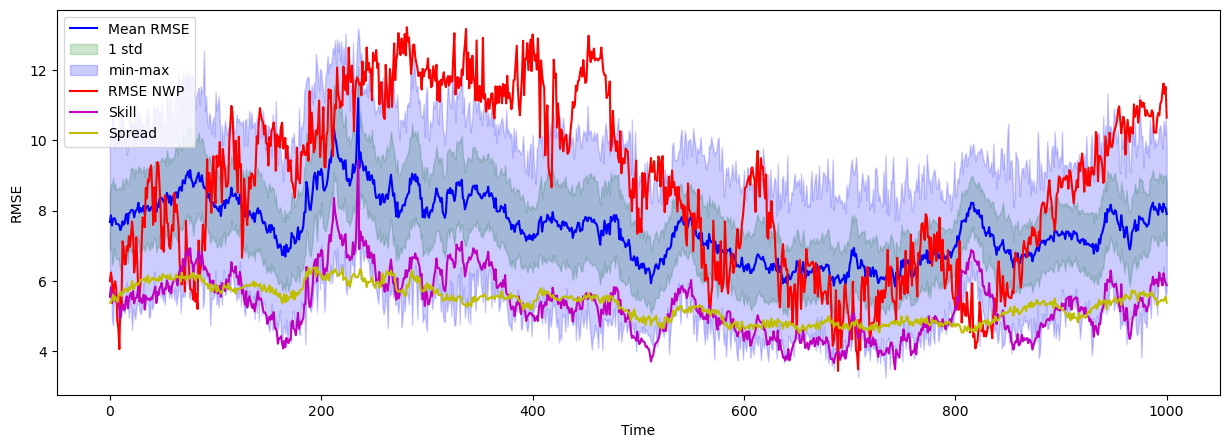

In [264]:
plt.figure(figsize=(15,5))

# Calculate the mean and standard deviation of rmse_model
mean_rmse = np.mean(rmse_model, axis=1)
std_rmse = np.std(rmse_model, axis=1)
min_rmse = np.min(rmse_model, axis=1)
max_rmse = np.max(rmse_model, axis=1)

# Plot the mean line
plt.plot(mean_rmse, label='Mean RMSE', color='blue')

# Plot the standard deviation band
plt.fill_between(range(len(mean_rmse)), mean_rmse - std_rmse, mean_rmse + std_rmse, alpha=0.2, color='green', label="1 std")
plt.fill_between(range(len(mean_rmse)), min_rmse, max_rmse, alpha=0.2, color='blue', label="min-max")
# Add labels and legend
plt.xlabel('Time')
plt.ylabel('RMSE')

# Show the plot

#plt.plot(rmse_model, label='RMSE Model', linewidth=0.05)
plt.plot(rmse_nwp, label='RMSE NWP', color='r')
#plt.plot(var_model, label='Var Model', color='g')
plt.plot(skill_model, label='Skill', color='m')
plt.plot(spread_model, label='Spread', color='y')
#plt.plot(crps_model, label='CRPS Model', color='c')
#plt.plot(brier_model, label='Brier Model', color='k')
plt.legend()
plt.show()

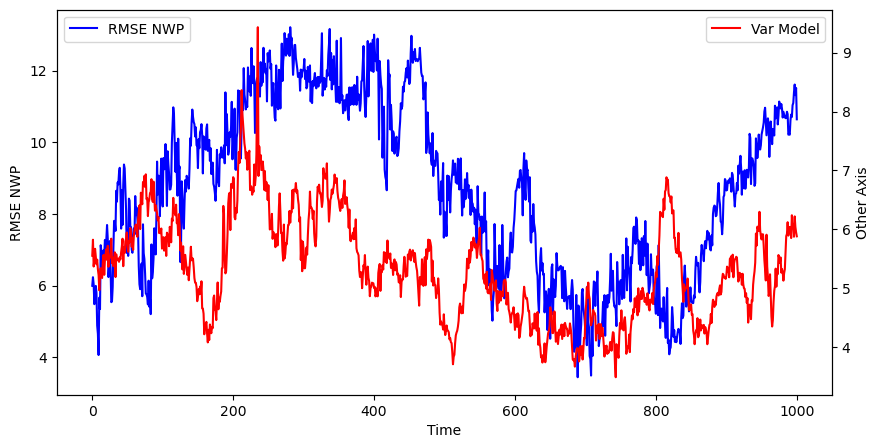

In [174]:
#plt.plot(var_model)
# Plot the rmse_nwp on a separate axis
x = np.arange(0, len(rmse_nwp))
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()
ax1.plot(x, rmse_nwp, color='blue', label='RMSE NWP')
ax1.set_xlabel('Time')
ax1.set_ylabel('RMSE NWP')
ax2.set_ylabel('Other Axis')
ax2.plot(x, sk_model, color='red', label='Var Model')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()


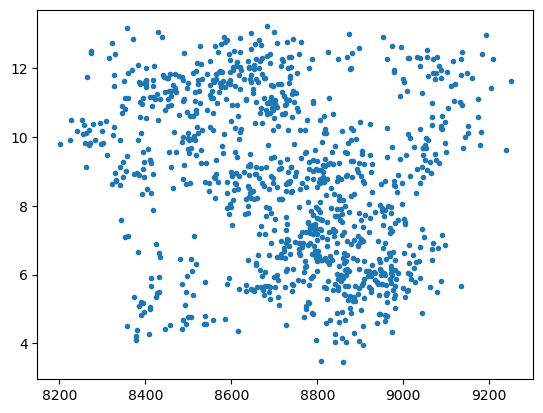

In [171]:
plt.plot(var_model, rmse_nwp, marker='.', linestyle='')
#plt.plot(var_model, rmse_model.mean(axis=1), marker='o', linestyle='')

### Likelihood

In [ ]:
def get_div_fn(fn):
  """Create the divergence function of `fn` using the Hutchinson-Skilling trace estimator."""

  def div_fn(x, t, eps, class_labels=None):
    with torch.enable_grad():
      x.requires_grad_(True)
      fn_eps = torch.sum(fn(x, t, class_labels) * eps, axis=(1,2,3))
      #print(x.shape, eps.shape, fn_eps.shape)
      grad_fn_eps = torch.zeros_like(eps)

      for i in range(eps.size(0)):
          dl = torch.autograd.grad(fn_eps[i], x, create_graph=True, allow_unused=True)[0]
          grad_fn_eps[i] = dl

    x.requires_grad_(False)
    res = torch.sum(grad_fn_eps * eps, dim=(1,2,3)).mean(dim=0)
    return res

  return div_fn


def div_fn(model, x, t, noise, class_labels=None):
    return get_div_fn(lambda xx, tt, class_labels: drift_fn(model, xx, tt, class_labels))(x, t, noise, class_labels)


In [ ]:
def likelihood_sampler(
    net, latents, samples, class_labels=None, randn_like=torch.randn_like,
    num_steps=18, sigma_min=0.002, sigma_max=80, rho=7,
    S_churn=0, S_min=0, S_max=float('inf'), S_noise=1,
    eps_multiplier=1,
):
    # Adjust noise levels based on what's supported by the network.
    sigma_min = max(sigma_min, net.sigma_min)
    sigma_max = min(sigma_max, net.sigma_max)

    # Time step discretization.
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=latents.device)
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    t_steps = torch.cat([net.round_sigma(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0

    # Main sampling loop.
    x_next = samples[0]
    
    # Need to make eps_shape one more dimension
    #eps_shape = (eps_multiplier,) + x_next.shape
    
    eps_shape = x_next.shape
    eps_shape = (eps_shape[0] * eps_multiplier,) + eps_shape[1:]  # Double the number of channels
    epsilon = torch.randn(eps_shape).to(device)
    #print(epsilon.shape)
    div_next = div_fn(net, x_next, t_steps[0], epsilon, class_labels)

    N = np.prod(latents.shape[1:])
    prior_logp = -N / 2. * np.log(2 * np.pi * sigma_max ** 2) - torch.sum(latents ** 2, dim=(1, 2, 3)) / (2 * sigma_max ** 2)
    prior_logp = prior_logp[0]
    #prior_logp = torch.tensor(0.0).to(device)
    post_logp = prior_logp# torch.tensor(0.0).to(device) # torch.zeros_like(prior_logp) #prior_logp

    #logps = [prior_logp]
    
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])): # 0, ..., N-1
        x_next = samples[i + 1]

        # Likelihood
        div_cur = div_next
        
        if i < num_steps - 1:
            epsilon = torch.randn(eps_shape).to(device)
            div_next = div_fn(net, x_next, t_next, epsilon, class_labels)
            delta_logp = (div_cur + div_next) * (t_next - t_cur) / 2
            
            post_logp += delta_logp
            #logps.append(delta_logp)

    return post_logp #, torch.stack(logps)


In [ ]:
torch.manual_seed(0)
model.eval()
sampler_fn = complete_edm_sampler
#likelihood_sampler

n_ens = 10
for previous, current in shuffled_val_loader:
    with torch.no_grad():
        batch_size = current.size(0)

        current_latent = autoencoder.encoder(current)
        previous_latent = autoencoder.encoder(previous)
        residual_latent = (current_latent - previous_latent) / std_residual_latent
        
        for i in range(batch_size):
            latents = torch.randn([n_ens, residual_latent.size(1), model.img_resolution, model.img_resolution], device=device)
            class_labels = previous_latent[i].repeat(n_ens, 1, 1, 1)

            predicted_residuals, predicted_residuals_list = sampler_fn(model, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, 
                                                                    num_steps=100, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)
            predicted_latent = class_labels + predicted_residuals * std_residual_latent
            
            predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

            predicted_unscaled = predicted * std_data + mean_data
            current_unscaled = current[i] * std_data + mean_data
            previous_unscaled = previous[i] * std_data + mean_data

            ensemble_rmses = ((predicted_unscaled - current_unscaled)**2).mean(dim=(2,3)).sqrt().cpu().detach().numpy().flatten()
            break
    break

    #current_unscaled = current_unscaled.cpu().detach().numpy()[0]
    #previous_unscaled = previous_unscaled.cpu().detach().numpy()[0]

In [ ]:
res_list = {}
eps_multiplier = 10

for j in range(n_ens):
    print("Ensemble ", j)
    res_tmp = []
    for i in range(1):
        logps = likelihood_sampler(model, latents[j].unsqueeze(0), predicted_residuals_list[:,j].unsqueeze(1), class_labels[j].unsqueeze(0), eps_multiplier=eps_multiplier,
                                      sigma_max=80, sigma_min=0.03, rho=7, num_steps=100, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)
        res_tmp.append(logps.item())
        print(logps.item())
    res_list[np.round(ensemble_rmses[j],3)] = res_tmp

sorted_keys = sorted(res_list.keys())

# Sort the data based on the sorted keys
sorted_data = [res_list[key] for key in sorted_keys]

plt.boxplot(sorted_data, labels=sorted_keys)
#plt.plot(logps_list)

#print("Std", np.array(res_list).std())

In [ ]:
def drift_fn(model, x, t, class_labels=None):
    """The drift function of the reverse-time SDE."""
    sigma = t
    D_x = model(x, sigma, class_labels)
    S_x = (D_x - x)/(sigma**2)
    return S_x


def get_div_fn(fn):
  """Create the divergence function of `fn` using the Hutchinson-Skilling trace estimator."""

  def div_fn(x, t, eps, class_labels=None):
    with torch.enable_grad():
      x.requires_grad_(True)
      fn_eps = torch.sum(fn(x, t, class_labels) * eps)
      grad_fn_eps = torch.autograd.grad(fn_eps, x)[0]
    x.requires_grad_(False)
    return torch.sum(grad_fn_eps * eps, dim=tuple(range(1, len(x.shape))))

  return div_fn


def div_fn(model, x, t, noise, class_labels=None):
    return get_div_fn(lambda xx, tt, class_labels: drift_fn(model, xx, tt, class_labels))(x, t, noise, class_labels)


def likelihood_sampler(
    net, latents, class_labels=None, randn_like=torch.randn_like,
    num_steps=18, sigma_min=0.002, sigma_max=80, rho=7,
    S_churn=0, S_min=0, S_max=float('inf'), S_noise=1,
):
    # Adjust noise levels based on what's supported by the network.
    sigma_min = max(sigma_min, net.sigma_min)
    sigma_max = min(sigma_max, net.sigma_max)

    # Time step discretization.
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=latents.device)
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    t_steps = torch.cat([net.round_sigma(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0

    # Main sampling loop.
    x_next = latents.to(torch.float64) * t_steps[0]

    epsilon = torch.randn_like(x_next)
    div_next = div_fn(net, x_next, t_steps[0], epsilon, class_labels)

    N = np.prod(latents.shape[1:])
    prior_logp = -N / 2. * np.log(2 * np.pi * sigma_max ** 2) - torch.sum(latents ** 2, dim=(1, 2, 3)) / (2 * sigma_max ** 2)

    post_logp = prior_logp

    xs = [x_next]
    logps = [post_logp]
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])): # 0, ..., N-1
        x_cur = x_next

        # Increase noise temporarily.
        gamma = min(S_churn / num_steps, np.sqrt(2) - 1) if S_min <= t_cur <= S_max else 0
        t_hat = net.round_sigma(t_cur + gamma * t_cur)
        x_hat = x_cur + (t_hat ** 2 - t_cur ** 2).sqrt() * S_noise * randn_like(x_cur)

        # Euler step.
        denoised = net(x_hat, t_hat, class_labels).to(torch.float64)
        d_cur = (x_hat - denoised) / t_hat
        x_next = x_hat + (t_next - t_hat) * d_cur

        # Apply 2nd order correction.
        if i < num_steps - 1:
            denoised = net(x_next, t_next, class_labels).to(torch.float64)
            d_prime = (x_next - denoised) / t_next
            x_next = x_hat + (t_next - t_hat) * (0.5 * d_cur + 0.5 * d_prime)
        
        xs.append(x_next)

        # Likelihood
        div_cur = div_next
        
        if i < num_steps - 1:
          div_next = div_fn(net, x_next, t_next, epsilon, class_labels)
          post_logp += (div_cur + div_next) * (t_next - t_cur) / 2
        else:
           post_logp += div_cur * (t_next - t_cur) / 2
        
        logps.append(post_logp)

    return x_next, torch.stack(xs[::-1]), post_logp, torch.stack(logps[::-1])


NameError: name 'torch' is not defined

### Sampling + Likelihood as in original paper

Slower than current method.

In [ ]:
from likelihood import get_likelihood_fn

for previous, current in val_loader:
    prev = autoencoder.encoder(previous)[0:10]#.unsqueeze(0)
    curr = autoencoder.encoder(current)[0:10]#.unsqueeze(0)
    break

likelihood_fn = get_likelihood_fn(model, atol=10, rtol=0.1)
res = likelihood_fn(model, curr, prev)
A = res[-1,:]

In [12]:
def generate_forecast_likelihood(model, previous, n_ens=10, sampler_fn=edm_sampler):
    model.eval()
    
    previous = previous.unsqueeze(0)
    previous_latent = autoencoder.encoder(previous)
    
    latents = torch.randn([n_ens, model.img_channels//2, model.img_resolution, model.img_resolution], device=device)
    class_labels = previous_latent.repeat(n_ens, 1, 1, 1)

    predicted_residuals, _  = sampler_fn(model, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)
    predicted_latent = class_labels + predicted_residuals * std_residual_latent
    predicted = autoencoder.decoder(predicted_latent.to(torch.float32))
    predicted_unscaled = predicted * std_data + mean_data

    also_sample, logp = likelihood_fn(model, latents, previous_latent)
    also_sample = class_labels + also_sample * std_residual_latent
    also_sample = autoencoder.decoder(also_sample.to(torch.float32))
    also_sample = also_sample * std_data + mean_data

    return predicted_unscaled, also_sample, logp

tensor([-15436.7246], device='cuda:0')


Text(0.5, 1.0, 'Current')

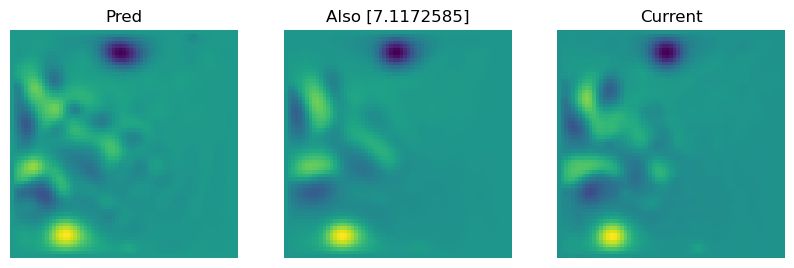

In [137]:
res = generate_forecast_likelihood(model, previous[0], n_ens=1)
pred, also_pred, logp = res
print(logp)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(pred.detach().cpu().numpy()[0,0])
axes[0].axis('off')
axes[0].set_title('Pred')

axes[1].imshow(also_pred.detach().cpu().numpy()[0,0])
axes[1].axis('off')
axes[1].set_title(f'Also {((also_pred - current[0])**2).mean(dim=(2,3)).sqrt().cpu().detach().numpy().flatten()}')


axes[2].imshow(current.detach().cpu().numpy()[0,0])
axes[2].axis('off')
axes[2].set_title('Current')
